<h1>DE</h1>

In [1]:
from data_loader import DataLoader 
from neural_network import NeuralNetwork
from visualizer import Visualizer
import tensorflow as tf
import numpy as np
import time
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
class DifferentialEvolution:
    def __init__(self, model, data_loader, pop_size=20, generations=5000, F=0.5, CR=0.7, initial_population=None, initial_fitness=None):
        self.model = model
        self.data_loader = data_loader
        self.pop_size = pop_size
        self.generations = generations
        self.F = F
        self.CR = CR
        self.dim = model.vector_size
        self.population = initial_population
        self.fitness = initial_fitness
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def train(self):
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize population
        if self.population is None or self.fitness is None:
            population = np.array([self.model.he_vector() for _ in range(self.pop_size)])
            fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in population])
        else:
            population = np.array(self.population)
            fitness = np.array(self.fitness)
        
        print(f"Starting Differential Evolution for {self.generations} generations...")
        
        for gen in range(self.generations):
            # To store offsprings
            new_pop = np.zeros_like(population)
            new_fit = np.zeros(self.pop_size)
            
            for i in range(self.pop_size):
                # Parent Selection
                idxs = np.delete(np.arange(self.pop_size), i)  # Target Vector
                
                # current/1 Mutation
                v1, v2, v3 = population[np.random.choice(idxs, 3, replace=False)]
                mutant = v1 + self.F * (v2 - v3)  # Mutant Vector
                
                # Crossover
                cross_points = np.random.rand(self.dim) < self.CR
                if not np.any(cross_points):
                    cross_points[np.random.randint(self.dim)] = True
                
                trial = np.where(cross_points, mutant, population[i])
                trial_fitness = self.model.fitness_function(trial, x_train, y_train)
                
                # Survivor Selection
                if trial_fitness <= fitness[i]:
                    new_pop[i] = trial
                    new_fit[i] = trial_fitness
                else:
                    new_pop[i] = population[i]
                    new_fit[i] = fitness[i]
            
            population = np.array(new_pop)
            fitness = np.array(new_fit)
            
            # Find best solution
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_loss = fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': population.copy(),
                    'fitness': fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [3]:
def run_differential_evolution(initial_population=None, initial_fitness=None):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    """Main function to run the Differential Evolution algorithm"""
    print("Running Neural Network with Differential Evolution optimization...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize DE optimizer
    de_optimizer = DifferentialEvolution(model, data_loader, pop_size=20, generations=3000, F=0.5, CR=0.7, initial_population=initial_population, initial_fitness=initial_fitness)
    
    # Train the model
    results = de_optimizer.train()
    
    # Save the model
    model.save_model('de_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with Differential Evolution optimization...
Starting Differential Evolution for 3000 generations...
Generation 1/3000 - Best loss: 2.2981 - Accuracy: 0.1385
Generation 101/3000 - Best loss: 2.1644 - Accuracy: 0.2366
Generation 201/3000 - Best loss: 2.0424 - Accuracy: 0.3119
Generation 301/3000 - Best loss: 1.8985 - Accuracy: 0.3365
Generation 401/3000 - Best loss: 1.7197 - Accuracy: 0.3840
Generation 501/3000 - Best loss: 1.4173 - Accuracy: 0.5163
Generation 601/3000 - Best loss: 1.2226 - Accuracy: 0.5750
Generation 701/3000 - Best loss: 1.0964 - Accuracy: 0.6240
Generation 801/3000 - Best loss: 0.9599 - Accuracy: 0.6669
Generation 901/3000 - Best loss: 0.8498 - Accuracy: 0.7068
Generation 1001/3000 - Best loss: 0.7725 - Accuracy: 0.7340
Generation 1101/3000 - Best loss: 0.7101 - Accuracy: 0.7504
Generation 1201/3000 - Best loss: 0.6605 - Accuracy: 0.7655
Generation 1301/3000 - Best loss: 0.6196 - Accuracy: 0.7898
Generation 1401/3000 - Best loss: 0.5722 - Accura

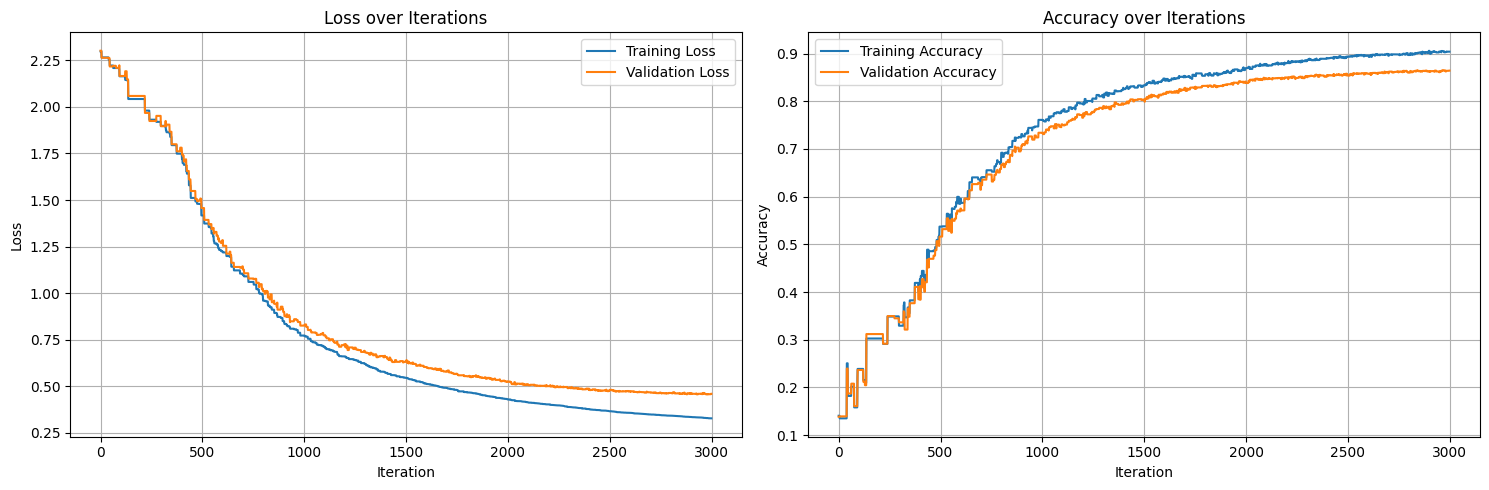

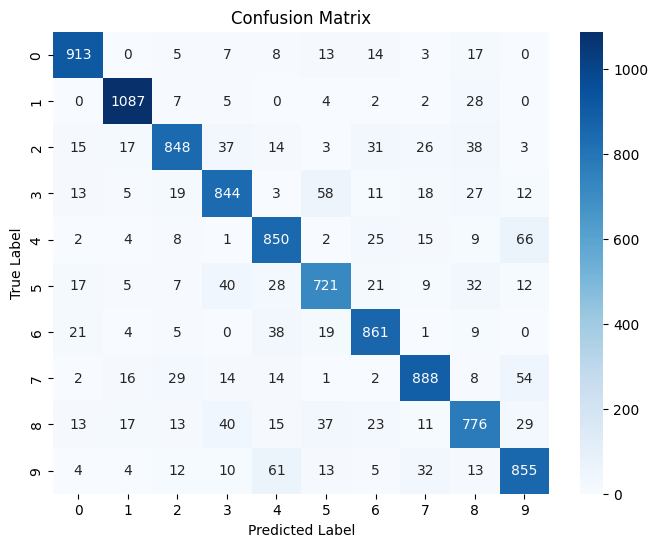

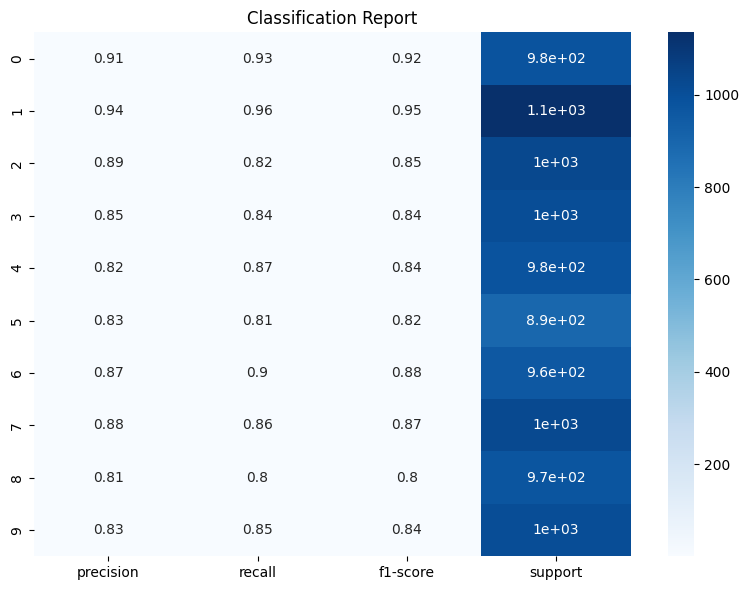

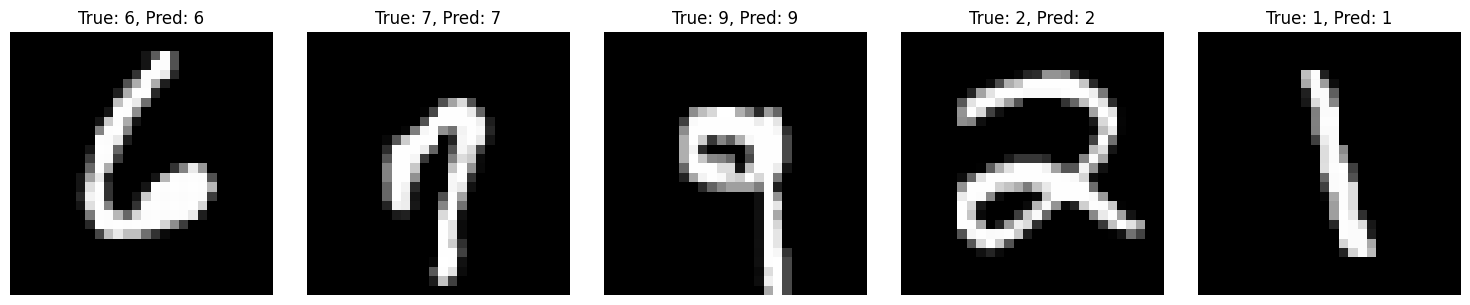

(<__main__.NeuralNetwork at 0x79ef583aa4d0>,
 {'best_loss': 0.4568331655524278,
  'final_loss': 0.4598482217428247,
  'final_accuracy': 0.8643,
  'total_iterations': 3000,
  'execution_time': 995.6747243404388,
  'history': {'loss': [2.2980979860172304,
    2.2980979860172304,
    2.2980979860172304,
    2.2980979860172304,
    2.2980979860172304,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
    2.2657371346385196,
  

In [140]:
run_differential_evolution()